# Feature Imputation with a Heat Flux Dataset
https://www.kaggle.com/c/playground-series-s3e15




In [47]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# Описание признаков

In [48]:
data = pd.read_csv("./data/data.csv")

### Описание колонок

author - Имя человека или группы, проводившей эксперимент

geometry - Тип геометрии, используемой в эксперименте, например, труба или кольцевое пространство

pressure [МПа] - Давление жидкости в эксперименте

mass_flux [кг / м2-с] - Массовый поток жидкости в эксперименте

D_e [мм] - Эквивалентный диаметр экспериментальной геометрии

D_h [мм] - Гидравлический диаметр экспериментальной геометрии

length [мм] - Длина экспериментальной геометрии, измеряемая в миллиметрах

chf_exp [МВт / м2] - Экспериментальный критический тепловой поток

**X_e_out [-] (target)** - Качество жидкости на выходе в эксперименте


In [49]:
data

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...,...
31639,31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,31640,NaN,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,31641,Thompson,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,31642,Thompson,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


In [50]:
data.rename(columns={'pressure [MPa]':'pressure',
                     'mass_flux [kg/m2-s]':'mass_flux',
                     'x_e_out [-]':'x_e_out', 
                     'D_e [mm]':'D_e', 
                     'D_h [mm]':'D_h', 
                     'length [mm]':'length',
                     'chf_exp [MW/m2]':'chf_exp'}, inplace=True)

In [51]:
data.describe()

,id,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
count,31644.000000,27192.000000,26853.000000,21229.000000,26156.000000,27055.000000,26885.000000,31644.000000
mean,15821.500000,10.640747,3068.011023,-0.000453,8.629255,14.174330,832.987391,3.796985
std,9134.980296,4.333683,1777.032080,0.100911,5.185692,19.838489,672.299239,1.983991
min,0.000000,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,7910.750000,6.890000,1519.000000,-0.046600,5.000000,5.600000,318.000000,2.400000
50%,15821.500000,11.070000,2731.000000,0.003800,7.800000,10.000000,610.000000,3.400000
75%,23732.250000,13.790000,4069.000000,0.064800,10.800000,11.500000,914.000000,4.600000
max,31643.000000,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


# Предобработка данных

### Трансформация признаков

In [52]:
data['D_e'] = np.log(data['D_e'])
data['D_h'] = np.log(data['D_h'])
data['length'] = np.log(data['length'])
data['chf_exp'] = np.log(data['chf_exp'])

### Заполнение пропусков

Заполнение NaN для D_e через D_h

In [53]:
data.loc[data['D_e'].isna(), 'D_e'] = data[data['D_e'].isna()]['D_h']
data.loc[data['D_h'].isna(), 'D_h'] = data[data['D_h'].isna()]['D_e']

In [54]:
X_train, y_train = data[~data.x_e_out.isna()][data.columns.drop('x_e_out')], data[~data.x_e_out.isna()]['x_e_out']
X_test, y_test = data[data.x_e_out.isna()][data.columns.drop('x_e_out')], data[data.x_e_out.isna()]['x_e_out']
print(y_train.shape, y_test.shape)

(21229,) (10415,)


In [55]:
numerical_features = data.select_dtypes(include=['number']).columns
categorial_features = data.columns.drop(numerical_features)
numerical_features = numerical_features.drop(['id', 'x_e_out'])

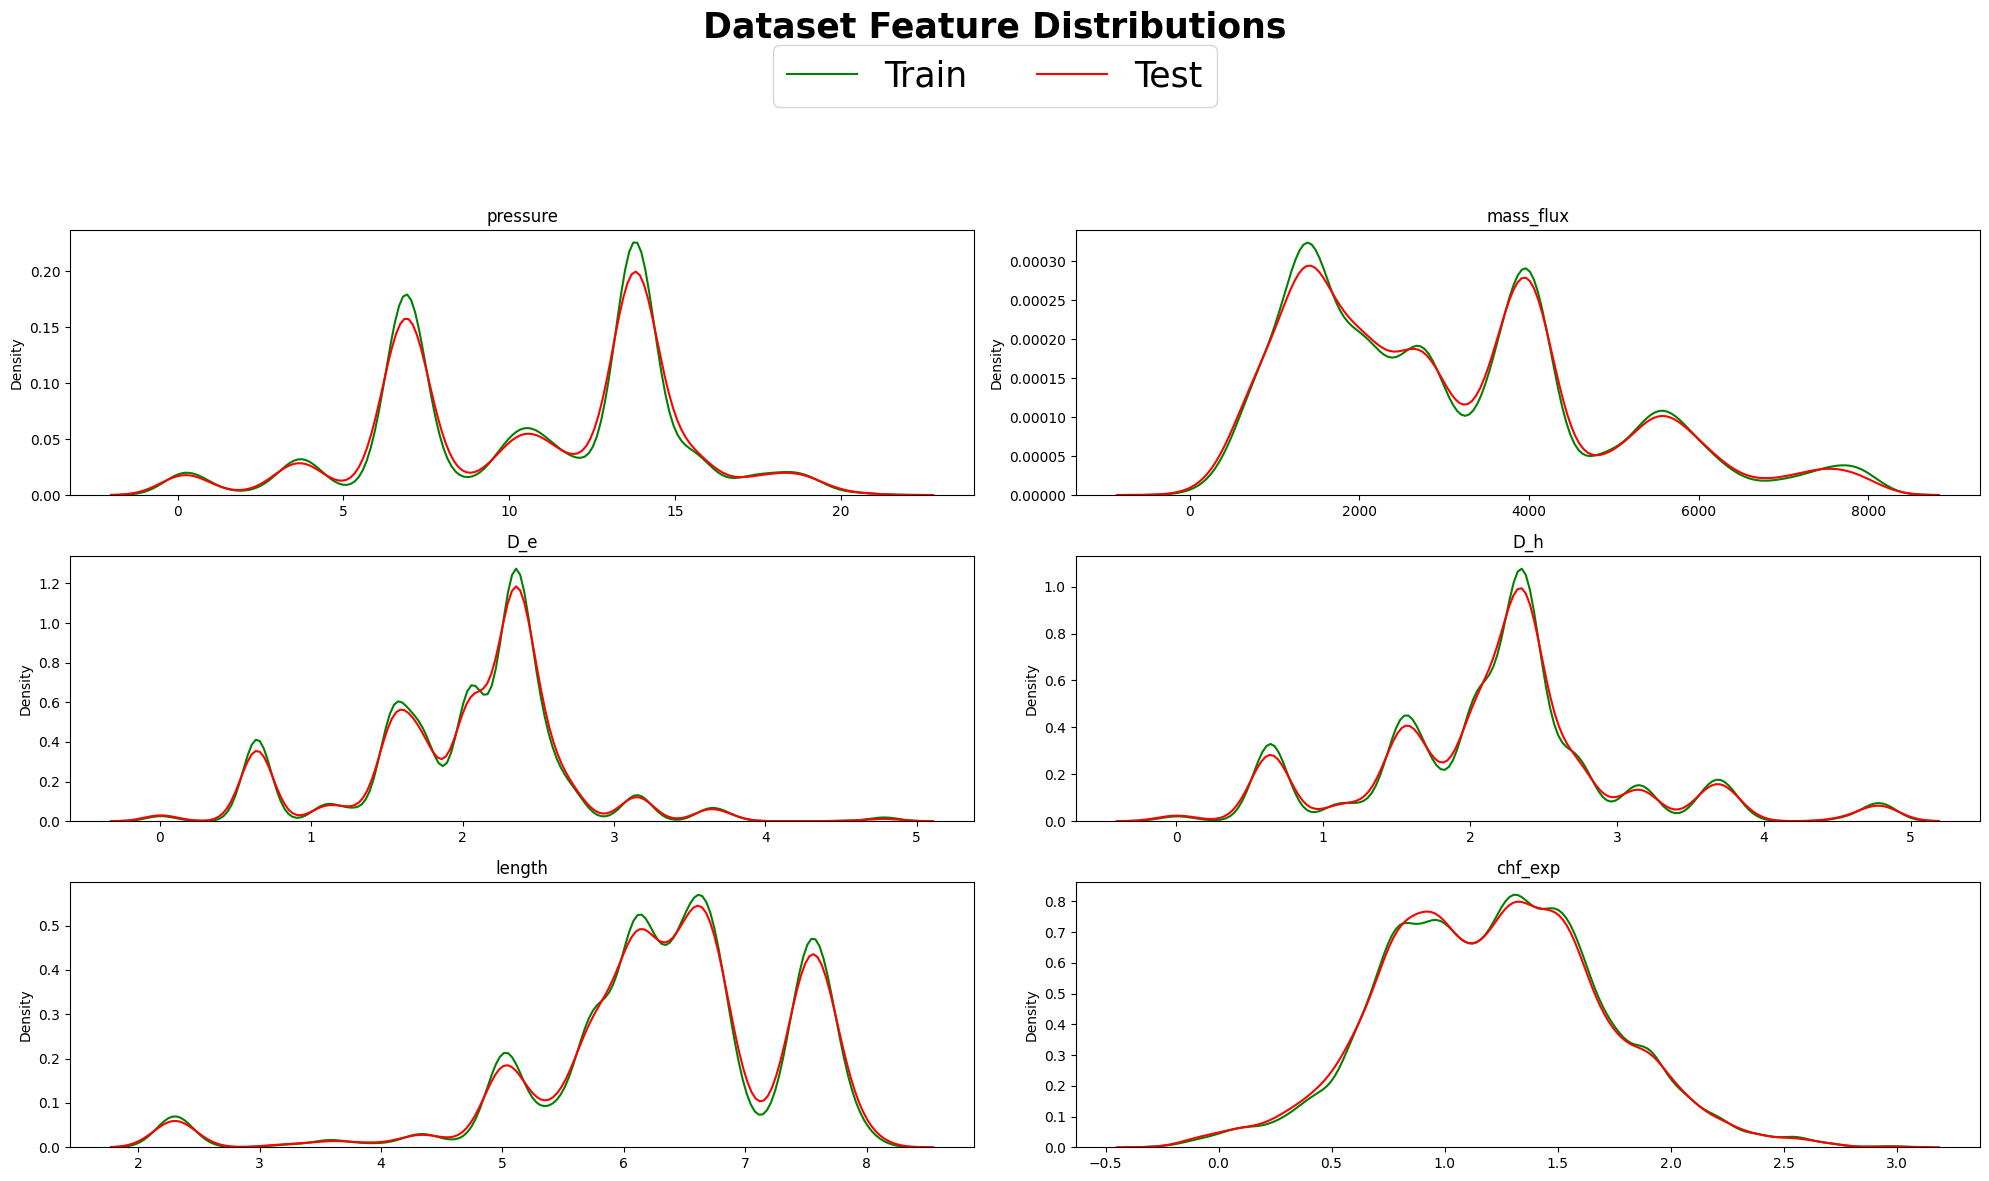

In [56]:
features = numerical_features
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        X_train[column], label='Train',
        ax=ax[i], color='g'
    )
    
    sns.kdeplot(
        X_test[column], label='Test',
        ax=ax[i], color='r'
    )

    # titles
    ax[i].set_title(f'{column}');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

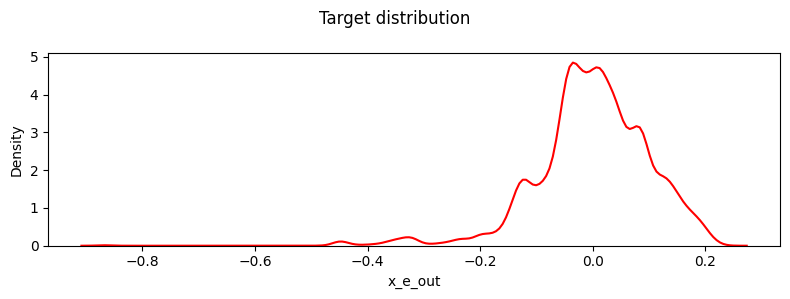

In [57]:
fig = plt.figure(figsize=(8,3))
sns.kdeplot(y_train, label='Train distribution', color='r')
fig.suptitle(f'Target distribution')
plt.tight_layout()

In [58]:
def fillna_cat_features(X_train, X_test):
    for col in categorial_features:
        X_train[col+'_is_NA'] = np.where(X_train[col].isna(), 1, 0)
        X_test[col+'_is_NA'] = np.where(X_test[col].isna(), 1, 0)
        
    X_train['author'] = X_train['author'].fillna(X_train['author'].mode()[0])
    X_test['author'] = X_test['author'].fillna(X_train['author'].mode()[0])

    mode_by_author = X_train.groupby('author')['geometry'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    X_train['geometry'] = X_train['geometry'].fillna(X_train['author'].map(mode_by_author))
    X_test['geometry'] = X_test['geometry'].fillna(X_test['author'].map(mode_by_author))

    return X_train[categorial_features].isna().sum()

fillna_cat_features(X_train, X_test)

author      0
geometry    0
dtype: int64

In [59]:
def fillna_num_features(X_train, X_test):
    for col in numerical_features:
        if X_train[col].isnull().sum() > 0 or X_test[col].isnull().sum() > 0:
            mode_by_geometry = X_train.groupby('geometry')[col].apply(lambda x: x.mean())
            X_train[col] = X_train[col].fillna(X_train['geometry'].map(mode_by_geometry))
            X_test[col] = X_test[col].fillna(X_test['geometry'].map(mode_by_geometry))

    return X_train[numerical_features].isna().sum()

fillna_num_features(X_train, X_test)

pressure     0
mass_flux    0
D_e          0
D_h          0
length       0
chf_exp      0
dtype: int64

### Кодирование признаков

In [60]:
X_train

,id,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA
0,0,Thompson,tube,7.000000,3770.000000,2.379546,2.379546,6.068426,1.280934,0,0
1,1,Thompson,tube,11.157708,6049.000000,2.332144,2.332144,6.635947,1.824549,0,0
2,2,Thompson,tube,13.790000,2034.000000,2.041220,2.041220,6.124683,0.916291,0,1
3,3,Beus,annulus,13.790000,3679.000000,1.722767,2.721295,7.665753,1.098612,0,0
5,5,Thompson,tube,17.240000,3648.000000,0.641854,0.641854,6.545350,1.280934,1,1
...,...,...,...,...,...,...,...,...,...,...,...
31636,31636,Thompson,tube,12.070000,3235.129469,0.641854,0.641854,5.023881,1.686399,1,1
31638,31638,Thompson,tube,11.157708,3648.000000,1.547563,1.547563,5.762051,2.197225,0,0
31639,31639,Thompson,tube,11.157708,1736.000000,2.054124,2.054124,6.381816,0.832909,0,1
31641,31641,Thompson,tube,18.270000,658.000000,1.098612,1.098612,5.010635,0.832909,0,1


In [61]:
ohe = OneHotEncoder()

train_encoded = ohe.fit_transform(X_train[categorial_features])
test_encoded = ohe.transform(X_test[categorial_features])

encoded_cols = ohe.get_feature_names_out(categorial_features)

X_train_cat_encoded = pd.DataFrame(train_encoded.toarray(), columns=encoded_cols, index=X_train.index)
X_test_cat_encoded = pd.DataFrame(test_encoded.toarray(), columns=encoded_cols, index=X_test.index)

X_train = pd.concat([X_train, X_train_cat_encoded], axis=1).drop(columns=categorial_features)
X_test = pd.concat([X_test, X_test_cat_encoded], axis=1).drop(columns=categorial_features)

In [62]:
del X_train['id']
del X_test['id']

In [63]:
X_train

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA,author_Beus,author_Inasaka,...,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,7.000000,3770.000000,2.379546,2.379546,6.068426,1.280934,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,11.157708,6049.000000,2.332144,2.332144,6.635947,1.824549,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,13.790000,2034.000000,2.041220,2.041220,6.124683,0.916291,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,13.790000,3679.000000,1.722767,2.721295,7.665753,1.098612,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,17.240000,3648.000000,0.641854,0.641854,6.545350,1.280934,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,12.070000,3235.129469,0.641854,0.641854,5.023881,1.686399,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31638,11.157708,3648.000000,1.547563,1.547563,5.762051,2.197225,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31639,11.157708,1736.000000,2.054124,2.054124,6.381816,0.832909,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31641,18.270000,658.000000,1.098612,1.098612,5.010635,0.832909,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [64]:
X_test

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA,author_Beus,author_Inasaka,...,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
4,13.790000,686.000000,2.406945,2.406945,6.124683,1.029619,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,18.000000,750.000000,2.302585,2.302585,7.408531,0.788457,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,11.157708,3235.129469,0.641854,0.641854,5.023881,1.163151,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12,6.890000,7500.000000,2.549445,2.549445,7.565275,1.568616,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
23,15.510000,1355.000000,1.722767,2.721295,7.665753,0.741937,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,11.030000,3235.129469,2.442347,2.442347,6.204566,0.693147,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31634,1.010000,2000.000000,2.708050,4.787492,2.302585,1.824549,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
31637,13.790000,688.000000,2.406945,2.406945,6.124683,0.832909,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
31640,13.790000,3235.129469,1.547563,1.547563,6.204566,1.360977,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Обучение модели



In [65]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgbm
import catboost

### Обучение

In [66]:
def cross_validate(X, y, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        
        cv_scores.append(mean_squared_error(y_pred, y_val))
        
    print("Mean RMSE: " , np.mean(cv_scores))

### XGBRegressor

In [67]:
xgb_params = {'n_estimators': 32,
              'max_depth': 6,
              'reg_lambda': 1e-1,}

In [68]:
xgb_model = xgb.XGBRegressor(**xgb_params)
cross_validate(X_train, y_train, xgb_model)

Mean RMSE:  0.005591247094929302


In [69]:
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### LGBMRegressor

In [70]:
lgbm_params = {'n_estimators': 64,
               'learning_rate': 0.15,
               'max_depth': 7,
               'lambda_l1': 1e-2,
               'reg_lambda': 1e-8,}

In [71]:
lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
cross_validate(X_train, y_train, lgbm_model)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 16983, number of used features: 21
[LightGBM] [Info] Start training from score -0.000883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [72]:
lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 21229, number of used features: 21
[LightGBM] [Info] Start training from score -0.000453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMRegressor(lambda_l1=0.01, learning_rate=0.15, max_depth=7, n_estimators=64,
              reg_lambda=1e-08)

### CatBoostRegressor

In [73]:
catboost_params = {'learning_rate': 0.05,
                   'l2_leaf_reg': 0.01,}

In [ ]:
catboost_model = catboost.CatBoostRegressor(**catboost_params)
cross_validate(X_train, y_train, catboost_model)

In [ ]:
catboost_model = catboost.CatBoostRegressor(**catboost_params)
catboost_model.fit(X_train, y_train)

In [76]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_cat = catboost_model.predict(X_test)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


In [77]:
y_pred = y_pred_xgb * 0.2 + y_pred_lgbm * 0.6 + y_pred_cat * 0.2
y_pred.shape

(10415,)

# Предсказание

In [78]:
linespace = pd.Index(range(X_train.index[-1]))
test_indexes = linespace[~linespace.isin(X_train.index)]
y_test_pred = pd.DataFrame(data={'id': test_indexes, 'x_e_out [-]': y_pred}, index=test_indexes)
y_test_pred.to_csv('submission.csv', index=False)